In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load DESeq2 results CSV
df = pd.read_csv('deseq2_results.csv')
# Assign condition (control or treated)
# Assuming the first 2 rows are control and the 3rd is treated
df['condition'] = ['control', 'control', 'HT'] * (len(df) // 3) + ['control'] * (len(df) % 3)  # Repeat the pattern based on data

# Remove rows with NA values in 'log2FoldChange' or 'pvalue'
df = df.dropna(subset=['log2FoldChange', 'pvalue'])

print(df.columns)



Index(['Unnamed: 0', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'condition'],
      dtype='object')


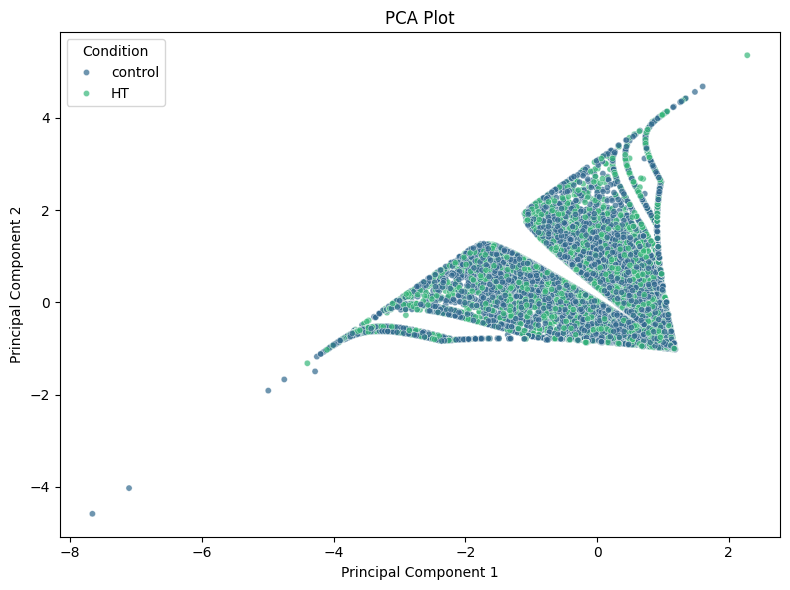

/tmp/ipykernel_1307749/131761097.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.text(row['log2FoldChange'], row['neg_log10_pvalue'], row[0], fontsize=6, ha='right', va='bottom'))


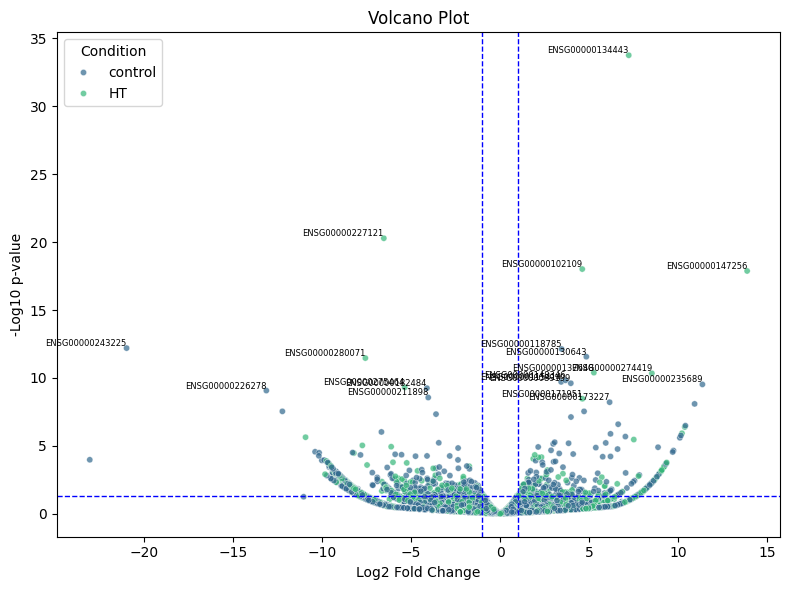

In [23]:


# 1. PCA Plot
# Extract the count data (log2FoldChange and pvalue might be used for annotation)
# Assuming 'log2FoldChange' and 'pvalue' are in the CSV
# Scale the counts (necessary for PCA)
pca_data = df[['log2FoldChange', 'pvalue']]  # Adjust column names based on your CSV structure
pca_data = pca_data.dropna()  # Remove any NaN values

# Standardize data
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)

# Apply PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(pca_data_scaled)


# PCA Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['condition'], palette='viridis', s=20, alpha=0.7)
plt.title('PCA Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Condition')
plt.tight_layout()
plt.savefig('pca_plot.png', dpi=300)
plt.show()

# Calculate -log10(p-value)
df['neg_log10_pvalue'] = -np.log10(df['pvalue'])

# Define significance for coloring
df['significant'] = (df['padj'] < 0.05) & (abs(df['log2FoldChange']) > 1)


# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='log2FoldChange',
    y='neg_log10_pvalue',
    data=df,
    hue='condition',  # Color by condition (Control vs HT)
    palette='viridis',  # Or change this palette to your preference
    s=20,
    alpha=0.7
)

# Add threshold lines
plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--', linewidth=1)
plt.axvline(x=1, color='blue', linestyle='--', linewidth=1)
plt.axvline(x=-1, color='blue', linestyle='--', linewidth=1)

# Label top 10 significant genes (using full gene IDs)
top_genes = df[df['significant']].nsmallest(20, 'padj')
texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row['log2FoldChange'], row['neg_log10_pvalue'], row[0], fontsize=6, ha='right', va='bottom'))

# Titles and labels
plt.title('Volcano Plot')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 p-value')
plt.legend(title='Condition', loc='upper left')
plt.tight_layout()

# Save plot
plt.savefig('volcano_plot_labeled.png', dpi=300)
plt.show()


In [24]:
# Save top 10 genes to a text file
top_genes_list = top_genes[[top_genes.columns[0]]]
top_genes_list.to_csv('top_10_DE_genes.txt', sep='\t', index=False)



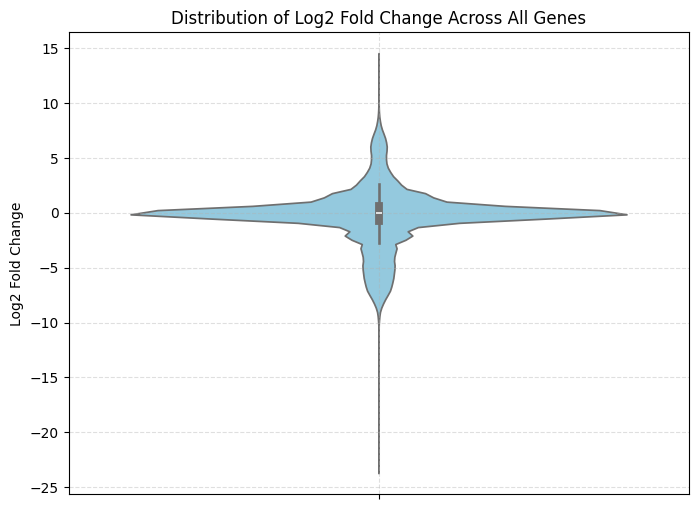

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Violin plot of log2FoldChange distribution
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, y='log2FoldChange', inner='box', color='skyblue')
plt.title('Distribution of Log2 Fold Change Across All Genes')
plt.ylabel('Log2 Fold Change')
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig("violin_log2FC_all_genes.png")
plt.show()


/tmp/ipykernel_1307749/239328784.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='significant', y='baseMean', inner='box', palette='Set2')


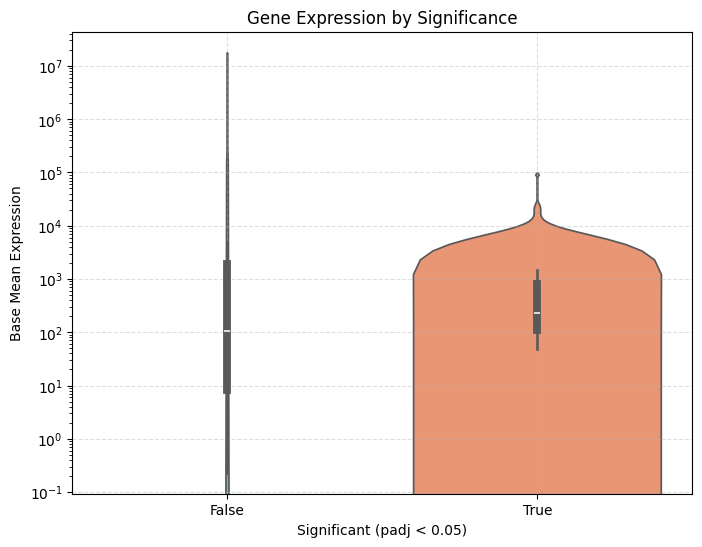

In [5]:
df['significant'] = df['padj'] < 0.05

# Violin plot of baseMean by significance
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='significant', y='baseMean', inner='box', palette='Set2')
plt.title('Gene Expression by Significance')
plt.xlabel('Significant (padj < 0.05)')
plt.ylabel('Base Mean Expression')
plt.yscale('log')  # expression is often log-scaled
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig("violin_expression_by_significance.png")
plt.show()




/tmp/ipykernel_1307749/4207765513.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=top_genes, x='direction', y='log2FoldChange', palette='coolwarm', inner='box')


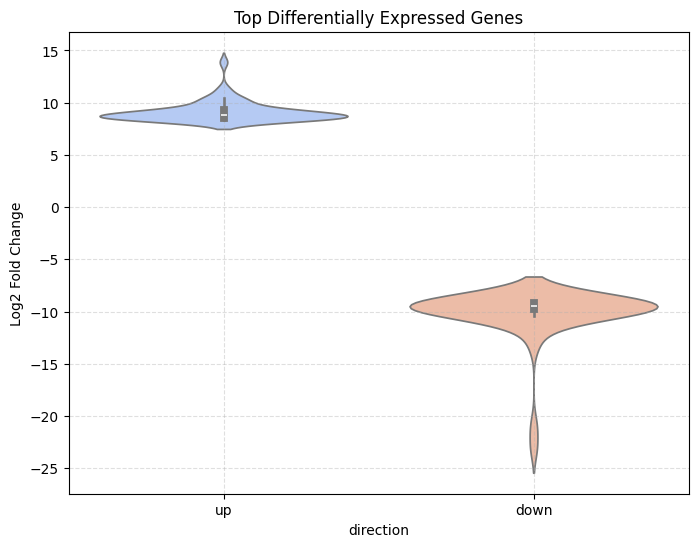

In [6]:
# Top 50 up/down
top_up = df.sort_values('log2FoldChange', ascending=False).head(50)
top_down = df.sort_values('log2FoldChange', ascending=True).head(50)
top_genes = pd.concat([top_up, top_down])
top_genes['direction'] = ['up']*50 + ['down']*50

# Violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=top_genes, x='direction', y='log2FoldChange', palette='coolwarm', inner='box')
plt.title('Top Differentially Expressed Genes')
plt.ylabel('Log2 Fold Change')
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig("violin_top_genes_log2FC.png")
plt.show()
